## Cumulos globulares

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

G=1.

## Integrador numérico

In [2]:
def RK4 (f, h, pos, vel, x, m, soft):
    k1=np.zeros(len (pos))
    k2=np.zeros(len (pos))
    k3=np.zeros(len (pos))
    k4=np.zeros(len (pos))
    kl1=np.zeros(len (vel))
    kl2=np.zeros(len (vel))
    kl3=np.zeros(len (vel))
    kl4=np.zeros(len (vel))
    k1, kl1=f(x,pos, vel, m, soft)
    k2, kl2=f(x+0.5*h, pos+0.5*k1, vel+0.5*kl1, m, soft)
    k3, kl3=f(x+0.5*h, pos+0.5*k2, vel+0.5*kl2, m, soft)
    k4, kl4=f(x+h, pos+k3, vel+kl3, m, soft)
    return pos+1/6*h*(k1+2*k2+2*k3+k4), vel+1/6*h*(kl1+2*kl2+2*kl3+kl4)

def RHS(x1, pos, vel, m, soft):
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2+soft**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ m
    ay = G * (dy * inv_r3) @ m
    az = G * (dz * inv_r3) @ m
    
    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return vel, a

## Inicialización del sistema

In [3]:
def Fill_initial_conditions (filename, massconv, lenghtconv, timeconv, l, t_min, t_max):
    initial=np.loadtxt(filename)
    N=initial.shape[0]
    datapos=np.zeros((N, 3, l))
    datavel=np.zeros((N, 3, l))
    M=np.zeros((N,1))
    for ii in range(N):
        datapos[ii, :, 0]=initial[ii, 0:3]/lenghtconv
        datavel[ii, :, 0]=initial[ii, 3:6]*timeconv/lenghtconv
        M[ii]=initial[ii,6]/massconv
    dom=np.linspace(t_min, t_max, l)
    return datapos, datavel, M, dom

def Gen_initial_conditions (filename, nparticles):
    data=np.zeros(shape=(nparticles, 7))
    for i in range (nparticles):
        u = np.random.random(1)
        v = np.random.random(1)
        theta = u * 2.0 * np.pi
        phi = np.arccos(2.0 * v - 1.0)
        r = np.cbrt(np.random.random(1))
        sinTheta = np.sin(theta)
        cosTheta = np.cos(theta)
        sinPhi = np.sin(phi)
        cosPhi = np.cos(phi)
        x = r * sinPhi * cosTheta
        y = r * sinPhi * sinTheta
        z = r * cosPhi
        
        m=np.random.random(1)*10
        data[i, :]=[x, y, z, 0, 0, 0, m]
    np.savetxt(filename, data, delimiter =' ')
    return 

## Evaluación de resultados

In [4]:
def getEnergy( pos, vel, mass, soft):
    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


    # Potential Energy:

    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r for all particle pairwise particle separations 
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2+soft**2)
    inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
    
    return KE/PE, KE, PE

def Mass_ev (pos, mass_array, n):
    aux=np.hstack((pos, mass_array))
    CM = np.average(aux[:,:3], axis=0, weights=aux[:,3])
    pos-=CM
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]
    r=np.sqrt(x**2+y**2+z**2)
    profile = np.linspace(np.min(r), np.max(r), 1000)
    mass =np.zeros(len(profile))
    for i in range (len(profile)):
        for j in range(len(r)):
            if (r[j]<profile[i]):
                mass[i]+= mass_array[j]
    return profile, mass

def Mass_ev_av (pos, mass_array, n):
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]
    r=np.sqrt(x**2+y**2+z**2)
    profile = np.linspace(np.min(r), np.max(r), 1000)
    mass =np.zeros(len(profile))
    for i in range (len(profile)-1):
        count=0
        for j in range(len(r)):
            if (profile[i]<r[j]<profile[i+1]):
                mass[i]+= mass_array[j]
                count+=1
        if(count!=0):
            mass[i]/=count
    return profile, mass

## Implementación

In [5]:
Gen_initial_conditions('data.txt', 100)

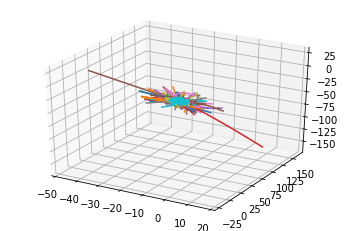

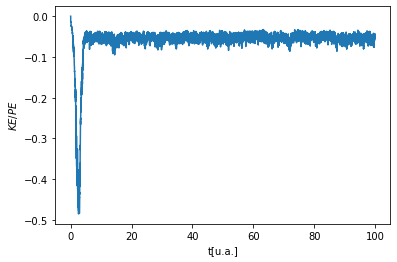

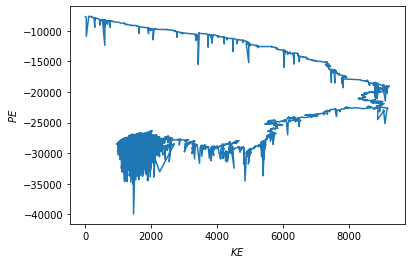

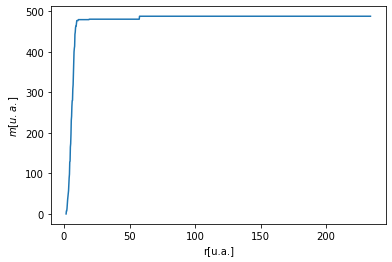

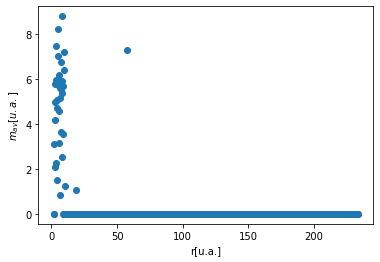

In [6]:
t_min = 0
t_max = 100
n = 100000
datapos, datavel, m, domain=Fill_initial_conditions('data.txt', 1., 1./20., 1., n, t_min, t_max)

for i in range (1,n):
    datapos[:,:,i], datavel[:,:,i]=RK4(RHS, (t_max-t_min)/n, datapos[:,:,i-1], datavel[:,:,i-1], domain[i-1], m, 0.015)
fig = plt.figure()
ax = fig.gca(projection='3d')
for ii in range(len(m)):
    ax.plot(datapos[ii, 0, :], datapos[ii, 1, :], datapos[ii, 2, :])

plt.show()
energy=np.zeros((len(domain),3))
for i in range(len(domain)):
    energy[i,0], energy[i,1], energy[i,2]=getEnergy(datapos[:,:,i], datavel[:,:, i], m, 0.015)
plt.figure()
plt.xlabel('t[u.a.]')
plt.ylabel(r'$KE/PE$')
plt.plot(domain, energy[:,0])
plt.savefig('fig2.pdf')
plt.show()

plt.figure()
plt.xlabel(r'$KE$')
plt.ylabel(r'$PE$')
plt.plot(energy[:,1], energy[:,2])
plt.savefig('fig5.pdf')
plt.show()

space, mass=Mass_ev(datapos[:,:,-1], m, 100)

plt.figure()
plt.xlabel('r[u.a.]')
plt.ylabel(r'$m[u.a.]$')
plt.plot(space, mass)
plt.savefig('fig3.pdf')
plt.show()

space, mass=Mass_ev_av(datapos[:,:,-1], m, 100)

plt.figure()
plt.xlabel('r[u.a.]')
plt.ylabel(r'$m_{av}[u.a.]$')
plt.scatter(space, mass)
plt.savefig('fig4.pdf')
plt.show()